<a href="https://colab.research.google.com/github/krsmith/DS-Unit-2-Sprint-2-Linear-Regression/blob/master/module2-polynomial-regression/Polynomial_Log_linear_Regression_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermediate Linear Regression Practice

## Use a Linear Regression model to get the lowest RMSE possible on the following dataset:

[Dataset Folder](https://github.com/ryanleeallred/datasets/tree/master/Ames%20Housing%20Data)

[Raw CSV](https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv)

## You model must include (at least):
- A log-transformed y variable
- Two polynomial features
- One interaction feature
- 10 other engineered features

What is the lowest Root-Mean-Squared Error that you are able to obtain? Share your best RMSEs in Slack!

Notes:

There may be some data cleaning that you need to do on some features of this dataset. Linear Regression will only accept numeric values and will not accept

Note* There may not be a clear candidate for an interaction term in this dataset. Include one anyway, sometimes it's a good practice for predictive modeling feature engineering in general. 

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [72]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [73]:
df.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


In [0]:
df.isna().sum()

#drop Alley, PoolQC, Fence, MiscFeature because of high % of NaNs

df.drop(columns=['Alley','PoolQC','Fence','MiscFeature'], axis=1, inplace=True)

ValueError: ignored

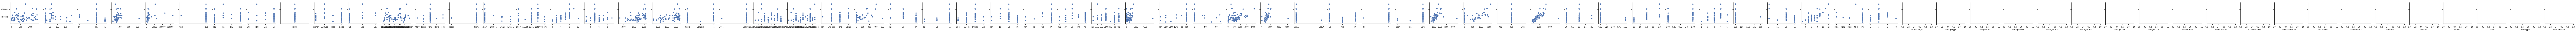

In [75]:
sns.set(style="ticks", color_codes=True)

# Generate a list of column headers not including price
x_columns = df.columns.drop('SalePrice')

# Sample our dataframe to take 1/20th the values
sampled = df.sample(frac=0.05, replace=True)
# print(x_columns)

# Only plot the scatterplot of x variables with our y variable
sns.pairplot(data=sampled, y_vars=['SalePrice'], x_vars=x_columns)

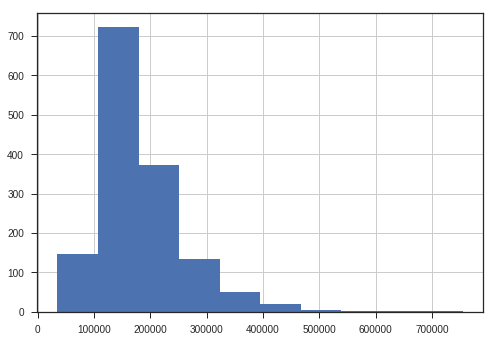

In [76]:
df['SalePrice'].hist()

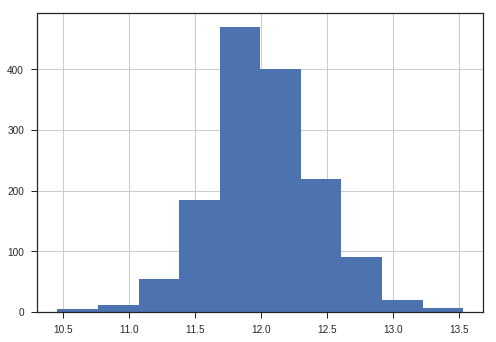

In [77]:
df['ln_SalePrice'] = np.log(df['SalePrice'])

df['ln_SalePrice'].hist()

In [78]:
df1 = df[['OverallQual', 'OverallCond', 'YearBuilt','YearRemodAdd','ExterCond',
     'Foundation','BsmtCond','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath',
     'BedroomAbvGr','TotRmsAbvGrd','GarageYrBlt','GarageCars','GarageArea','ln_SalePrice']]

df1.head()


,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterCond,Foundation,BsmtCond,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,BedroomAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,ln_SalePrice
0,7,5,2003,2003,TA,PConc,TA,856,856,1710,2,3,8,2003.0,2,548,12.247694
1,6,8,1976,1976,TA,CBlock,TA,1262,1262,1262,2,3,6,1976.0,2,460,12.109011
2,7,5,2001,2002,TA,PConc,TA,920,920,1786,2,3,6,2001.0,2,608,12.317167
3,7,5,1915,1970,TA,BrkTil,Gd,756,961,1717,1,3,7,1998.0,3,642,11.849398
4,8,5,2000,2000,TA,PConc,TA,1145,1145,2198,2,4,9,2000.0,3,836,12.429216


In [79]:
df1['ExterCond'].unique()

df1['ExterCond']= df1['ExterCond'].map({'TA':2, 'Gd':3, 'Fa':1, 'Po':0, 'Ex':4})
#Ex	Excellent
#Gd	Good
#TA	Average/Typical
#Fa	Fair
#Po	Poor

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
df1['Foundation'].unique()

df1['Foundation']= df1['Foundation'].map({'PConc':5, 'CBlock':2, 'BrkTil':1, 'Wood':0, 'Slab':4, 'Stone':3})

#BrkTil	Brick & Tile
#CBlock	Cinder Block
#PConc	Poured Contrete	
#Slab	Slab
#Stone	Stone
#Wood	Wood

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
df1['BsmtCond'].unique()

df1['BsmtCond']= df1['BsmtCond'].map({'TA':2, 'Gd':3, 'Fa':1, 'Po':0, 'Ex':4})
#Ex	Excellent
#Gd	Good
#TA	Average/Typical
#Fa	Fair
#Po	Poor

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
df1.describe()

,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterCond,Foundation,BsmtCond,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,BedroomAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,ln_SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1423.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,5.575342,1971.267808,1984.865753,2.083562,3.262329,2.011244,1057.429452,1162.626712,1515.463699,1.565068,2.866438,6.517808,1978.506164,1.767123,472.980137,12.024051
std,1.382997,1.112799,30.202904,20.645407,0.351054,1.604596,0.287846,438.705324,386.587738,525.480383,0.550916,0.815778,1.625393,24.689725,0.747315,213.804841,0.399452
min,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,334.000000,0.000000,0.000000,2.000000,1900.000000,0.000000,0.000000,10.460242
25%,5.000000,5.000000,1954.000000,1967.000000,2.000000,2.000000,2.000000,795.750000,882.000000,1129.500000,1.000000,2.000000,5.000000,1961.000000,1.000000,334.500000,11.775097
50%,6.000000,5.000000,1973.000000,1994.000000,2.000000,2.000000,2.000000,991.500000,1087.000000,1464.000000,2.000000,3.000000,6.000000,1980.000000,2.000000,480.000000,12.001505
75%,7.000000,6.000000,2000.000000,2004.000000,2.000000,5.000000,2.000000,1298.250000,1391.250000,1776.750000,2.000000,3.000000,7.000000,2002.000000,2.000000,576.000000,12.273731
max,10.000000,9.000000,2010.000000,2010.000000,4.000000,5.000000,3.000000,6110.000000,4692.000000,5642.000000,3.000000,8.000000,14.000000,2010.000000,4.000000,1418.000000,13.534473


In [84]:
df1.isna().sum()

OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
ExterCond        0
Foundation       0
BsmtCond        37
TotalBsmtSF      0
1stFlrSF         0
GrLivArea        0
FullBath         0
BedroomAbvGr     0
TotRmsAbvGrd     0
GarageYrBlt     81
GarageCars       0
GarageArea       0
ln_SalePrice     0
dtype: int64

In [85]:
df1['GarageYrBlt'] = df1['GarageYrBlt'].fillna(df1['GarageYrBlt'].mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [86]:
df1.isna().sum()

OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
ExterCond        0
Foundation       0
BsmtCond        37
TotalBsmtSF      0
1stFlrSF         0
GrLivArea        0
FullBath         0
BedroomAbvGr     0
TotRmsAbvGrd     0
GarageYrBlt      0
GarageCars       0
GarageArea       0
ln_SalePrice     0
dtype: int64

In [87]:
df1['BsmtCond'] = df1['BsmtCond'].fillna(-1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [88]:
df1.isna().sum()

OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
ExterCond       0
Foundation      0
BsmtCond        0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
FullBath        0
BedroomAbvGr    0
TotRmsAbvGrd    0
GarageYrBlt     0
GarageCars      0
GarageArea      0
ln_SalePrice    0
dtype: int64

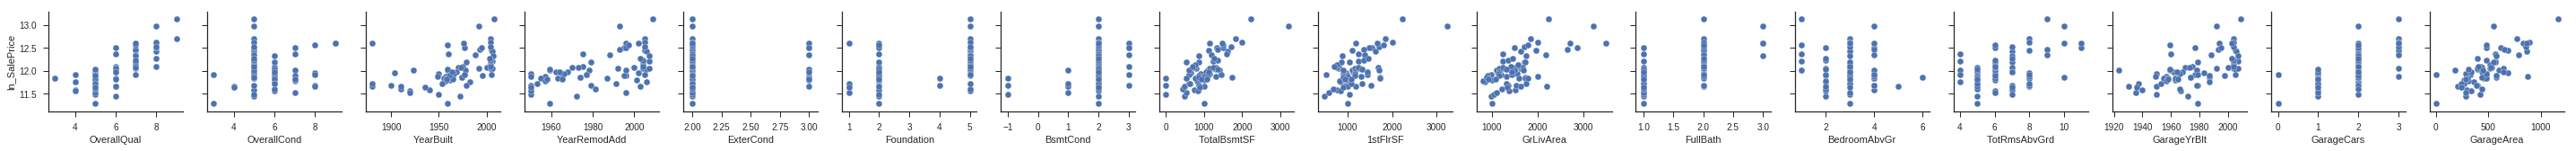

In [89]:
sns.set(style="ticks", color_codes=True)

# Generate a list of column headers not including price
x_columns = df1.columns.drop('ln_SalePrice')

# Sample our dataframe to take 1/20th the values
sampled = df1.sample(frac=0.05, replace=True)
# print(x_columns)

# Only plot the scatterplot of x variables with our y variable
sns.pairplot(data=sampled, y_vars=['ln_SalePrice'], x_vars=x_columns)

In [92]:
#Choosing 1stFlrSF & GrLivArea for polynomial features

df1['1stFlrSF_squared'] = df1['1stFlrSF']**2
df1['GrLivArea_squared'] = df1['GrLivArea']**2

df1.columns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Index(['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterCond',
       'Foundation', 'BsmtCond', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea',
       'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'ln_SalePrice', '1stFlrSF_squared', 'GrLivArea_squared'],
      dtype='object')

In [95]:
#Testing without polynomial features but with log of y

## Non-Feature Engineered Model
# Separate dependent and independent variables
y = df1.loc[:, ['ln_SalePrice']].values
X = df1.loc[:, ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterCond',
       'Foundation', 'BsmtCond', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea',
       'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea']].values

# Slit into test and train datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.5, random_state=42)

# fit model using train datasets
model = LinearRegression()
model.fit(X_train, Y_train)

# Create new predictions using x_test
y_pred = model.predict(X_test)

# Measure Accuracy using y_test and y_pred
RMSE = (np.sqrt(mean_squared_error(Y_test, y_pred)))
R2 = r2_score(Y_test, y_pred)

print('RMSE is {}'.format(RMSE))
print('R^2 is {}'.format(R2))

print("coefficients: ", model.coef_[0])
print("intercepts: ", model.intercept_)

RMSE is 0.16039545846389955
R^2 is 0.8457225407320484
coefficients:  [ 8.16845674e-02  5.26151793e-02  3.23610529e-03  8.73558968e-04
 -2.52530404e-02  1.05801611e-02  5.14991403e-02 -2.71499378e-05
  1.59042448e-04  2.32379669e-04 -9.29320515e-03 -9.34387659e-03
  4.89529371e-03 -6.49303037e-04  1.09523795e-01 -8.02844108e-06]
intercepts:  [3.6353725]


In [96]:
#Now testing WITH polynomial features and log of y

## Non-Feature Engineered Model
# Separate dependent and independent variables
y = df1.loc[:, ['ln_SalePrice']].values
X = df1.loc[:, ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterCond',
       'Foundation', 'BsmtCond', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea',
       'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea', '1stFlrSF_squared', 'GrLivArea_squared']].values

# Slit into test and train datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.5, random_state=42)

# fit model using train datasets
model = LinearRegression()
model.fit(X_train, Y_train)

# Create new predictions using x_test
y_pred = model.predict(X_test)

# Measure Accuracy using y_test and y_pred
RMSE = (np.sqrt(mean_squared_error(Y_test, y_pred)))
R2 = r2_score(Y_test, y_pred)

print('RMSE is {}'.format(RMSE))
print('R^2 is {}'.format(R2))

print("coefficients: ", model.coef_[0])
print("intercepts: ", model.intercept_)

#RMSE is lower

RMSE is 0.14711821504278305
R^2 is 0.8702070098794645
coefficients:  [ 6.61954568e-02  6.47506898e-02  3.46105767e-03  7.60048244e-04
 -2.27530670e-02  1.04563418e-02  4.66542746e-03  1.44396265e-04
  4.72509198e-04  5.32624077e-04 -2.88097350e-02 -2.70505108e-02
 -4.12889378e-03 -4.32047470e-04  4.18293902e-02  1.37446308e-04
 -1.59750250e-07 -5.11696135e-08]
intercepts:  [2.66267445]


In [98]:
# Creating interaction feature and testing model with it

df1['Condition'] = df1['OverallCond']*df1['ExterCond']

## Non-Feature Engineered Model
# Separate dependent and independent variables
y = df1.loc[:, ['ln_SalePrice']].values
X = df1.loc[:, ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterCond',
       'Foundation', 'BsmtCond', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea',
       'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea', '1stFlrSF_squared', 'GrLivArea_squared','Condition']].values

# Slit into test and train datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.5, random_state=42)

# fit model using train datasets
model = LinearRegression()
model.fit(X_train, Y_train)

# Create new predictions using x_test
y_pred = model.predict(X_test)

# Measure Accuracy using y_test and y_pred
RMSE = (np.sqrt(mean_squared_error(Y_test, y_pred)))
R2 = r2_score(Y_test, y_pred)

print('RMSE is {}'.format(RMSE))
print('R^2 is {}'.format(R2))

print("coefficients: ", model.coef_[0])
print("intercepts: ", model.intercept_)

#RMSE didn't change much at all, increased slightly

RMSE is 0.14741418370657008
R^2 is 0.8696842561381009
coefficients:  [ 6.63317371e-02  4.92683658e-02  3.50315109e-03  7.20692671e-04
 -6.98017857e-02  1.06844617e-02  4.22916588e-03  1.46883891e-04
  4.69851397e-04  5.34099097e-04 -2.80137406e-02 -2.70189073e-02
 -4.08540222e-03 -4.75773886e-04  4.15874551e-02  1.40837172e-04
 -1.59756528e-07 -5.16336758e-08  7.58230428e-03]
intercepts:  [2.83529221]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [147]:
#Adding more engineered features

df1['has_pool'] = np.where(df['PoolArea'] > 0, 1, 0)
df1['has_basement'] = np.where(df['TotalBsmtSF'] > 0, 1, 0)
df1['has_garage'] = np.where(df['GarageArea'] > 0, 1,0)
df1['tot_up_bath'] = df['FullBath'] + df['HalfBath']
df1['tot_down_bath'] = df['BsmtFullBath'] + df['BsmtHalfBath']
df1['tot_bath'] = df1['tot_up_bath'] + df1['tot_down_bath']
df1['gar_area_per_car'] = df['GarageArea'] / df['GarageCars']
df1['age_sold'] = df['YrSold'] - df['YearBuilt']
df1['remod_age'] = df['YearRemodAdd'] - df['YearBuilt']
df1['garage_age'] = df['GarageYrBlt'] - df['YearBuilt']
df1['base_finished'] = np.where(df['BsmtFinSF2'] > 0, 1,0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [148]:
df1['gar_area_per_car'].isna().sum()

df1['gar_area_per_car'] = df1['gar_area_per_car'].fillna(0)
df1['garage_age'] = df1['garage_age'].fillna(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [149]:
## Non-Feature Engineered Model
# Separate dependent and independent variables
y = df1.loc[:, ['ln_SalePrice']].values
X = df1.loc[:, ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterCond',
       'Foundation', 'BsmtCond', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea',
       'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea', '1stFlrSF_squared', 'GrLivArea_squared','Condition',
        'has_pool','has_basement','has_garage','tot_up_bath','gar_area_per_car',
        'age_sold','remod_age','garage_age','base_finished','tot_down_bath',
        'tot_bath']].values

# Slit into test and train datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.5, random_state=42)

# fit model using train datasets
model = LinearRegression()
model.fit(X_train, Y_train)

# Create new predictions using x_test
y_pred = model.predict(X_test)

# Measure Accuracy using y_test and y_pred
RMSE = (np.sqrt(mean_squared_error(Y_test, y_pred)))
R2 = r2_score(Y_test, y_pred)

print('RMSE is {}'.format(RMSE))
print('R^2 is {}'.format(R2))

print("coefficients: ", model.coef_[0])
print("intercepts: ", model.intercept_)

#Lowest RMSE is including all 10 engineered features

RMSE is 0.1458224657182194
R^2 is 0.8724832549650297
coefficients:  [ 7.16307006e-02  3.54153076e-02 -3.97540075e-05  4.47318022e-04
 -1.00953996e-01  1.29233354e-02  2.73265727e-02  1.61729488e-04
  5.01936961e-04  4.28190660e-04 -5.07448604e-02 -2.05877865e-02
 -3.20841331e-03 -3.91854726e-04  4.98669690e-02  6.25647753e-05
 -1.67926787e-07 -3.87855717e-08  1.19376659e-02 -7.84752400e-02
 -1.60356147e-01  2.88364054e-02  1.85902058e-02  9.88697068e-05
 -3.17594128e-03  4.87072033e-04  2.49987722e-04  8.58705759e-03
  1.93931019e-02  3.79833077e-02]
intercepts:  [10.39588128]


In [117]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

# Stretch Goals

- Write a blog post explaining one of today's topics.
- Find a new regression dataset from the UCI machine learning repository and use it to test out your new modeling skillz.
 [ - UCI Machine Learning Repository - Regression Datasets](https://)
- Make a list for yourself of common feature engineering techniques. Browse Kaggle kernels to learn more methods.
- Start studying for tomorrow's topic: Gradient Descent
- Try and make the ultimate model with this dataset. clean as many features as possible, engineer the most sensible features as possible and see how accurate of a prediction you can make. 
- Learn about the "Dummy Variable Trap" and how it applies to linear regression modeling.
- Learning about using linear regression to model time series data